In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Load the malaria dataset
file_path = 'C:/Users/admin/Desktop/malaria_cases.xlsx'
data = pd.read_excel(file_path)

# Inspect the first few rows of the data
data.head()

,District,Period,Fever case tested for Malaria (RDT) - Positive
0,Bo District,January 2018,14082
1,Bo District,February 2018,13089
2,Bo District,March 2018,14408
3,Bo District,April 2018,15433
4,Bo District,May 2018,16956


In [3]:
# Convert the "Period" column to a datetime format and set it as the index
data['Period'] = pd.to_datetime(data['Period'], format='%B %Y')
data.set_index('Period', inplace=True)

# Rename the relevant column
data.rename(columns={'Fever case tested for Malaria (RDT) - Positive': 'Malaria_Positive_Cases'}, inplace=True)

# Aggregate the data by month to ensure it's in time series format
monthly_cases = data['Malaria_Positive_Cases'].resample('M').sum()

# Check the cleaned time series data
monthly_cases.head()

Period
2018-01-31    119840
2018-02-28    108722
2018-03-31    117608
2018-04-30    128602
2018-05-31    137926
Freq: M, Name: Malaria_Positive_Cases, dtype: int64

In [4]:
# Check for missing values in the dataset
missing_values = monthly_cases.isnull().sum()

# Extract month and year from the index for feature engineering
data_preprocessed = monthly_cases.to_frame()
data_preprocessed['Month'] = data_preprocessed.index.month
data_preprocessed['Year'] = data_preprocessed.index.year

# Display the missing values count and the updated dataset with new features
missing_values, data_preprocessed.head()

(0,
             Malaria_Positive_Cases  Month  Year
 Period                                         
 2018-01-31                  119840      1  2018
 2018-02-28                  108722      2  2018
 2018-03-31                  117608      3  2018
 2018-04-30                  128602      4  2018
 2018-05-31                  137926      5  2018)

In [5]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the 'Malaria_Positive_Cases' column
data_preprocessed['Cases_Normalized'] = scaler.fit_transform(data_preprocessed[['Malaria_Positive_Cases']])

# Check the first few rows to confirm normalization
data_preprocessed[['Malaria_Positive_Cases', 'Cases_Normalized']].head()

,Malaria_Positive_Cases,Cases_Normalized
Period,,
2018-01-31,119840,0.264822
2018-02-28,108722,0.160901
2018-03-31,117608,0.243959
2018-04-30,128602,0.346722
2018-05-31,137926,0.433874


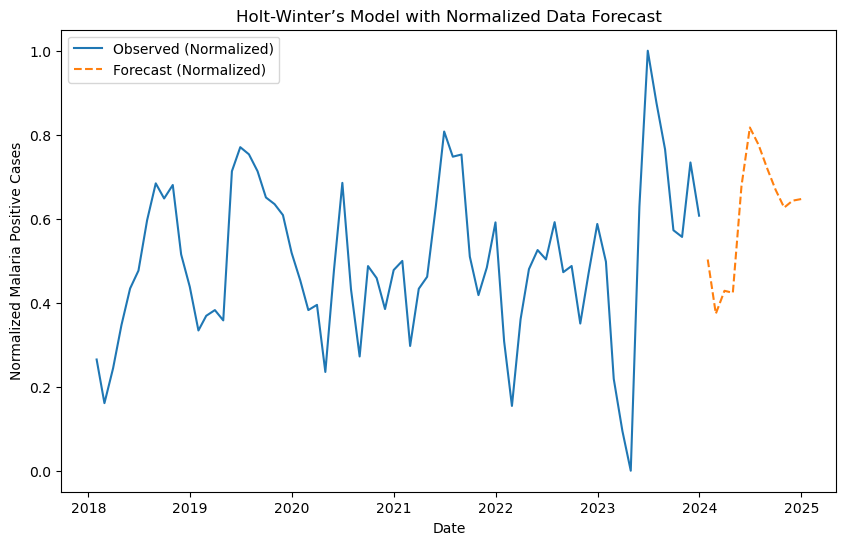

Dep. Variable:,Cases_Normalized,No. Observations:,72
Model:,ExponentialSmoothing,SSE,1.002
Optimized:,True,AIC,-275.756
Trend:,Additive,BIC,-239.330
Seasonal:,Additive,AICC,-262.851
Seasonal Periods:,12,Date:,"Thu, 10 Oct 2024"
Box-Cox:,False,Time:,14:32:41
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


In [6]:
# Use the normalized data for Holt-Winter's model fitting
normalized_cases = data_preprocessed['Cases_Normalized']

# Fit the Holt-Winter’s model with the normalized data - seasonal='multiplicative'/'add'
model_normalized = ExponentialSmoothing(normalized_cases, trend='add', seasonal='add', seasonal_periods=12)
fitted_model_normalized = model_normalized.fit()

# Forecast for the next 12 months based on the normalized data
forecast_normalized = fitted_model_normalized.forecast(steps=12)

# Plot the original normalized data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(normalized_cases, label='Observed (Normalized)')
plt.plot(forecast_normalized, label='Forecast (Normalized)', linestyle='--')
plt.title('Holt-Winter’s Model with Normalized Data Forecast')
plt.xlabel('Date')
plt.ylabel('Normalized Malaria Positive Cases')
plt.legend()
plt.show()

# Display model summary after normalization
fitted_model_normalized.summary()


In [8]:
def calculate_metrics(actual, predicted):
    # Calculate residuals
    residuals = actual - predicted
    
    # Calculate MAE
    mae = mean_absolute_error(actual, predicted)
    
    # Calculate RMSE
    rmse = mean_squared_error(actual, predicted, squared=False)
    
    # Calculate MASE
    naive_forecast = actual.shift(1).dropna()
    mase = mean_absolute_error(actual[1:], predicted[1:]) / mean_absolute_error(actual[1:], naive_forecast)
    
    # Calculate MAPE (safely handling zero/small values)
    non_zero_mask = actual > 0
    mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    
    return mae, mape, rmse, mase

# Calculate metrics
mae, mape, rmse, mase = calculate_metrics(normalized_cases, fitted_model_normalized.fittedvalues)

# Display the metrics
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"RMSE: {rmse:.4f}")
print(f"MASE: {mase:.4f}")

MAE: 0.0948
MAPE: 22.5277%
RMSE: 0.1180
MASE: 0.8096


# RESIDUAL ANALYSIS

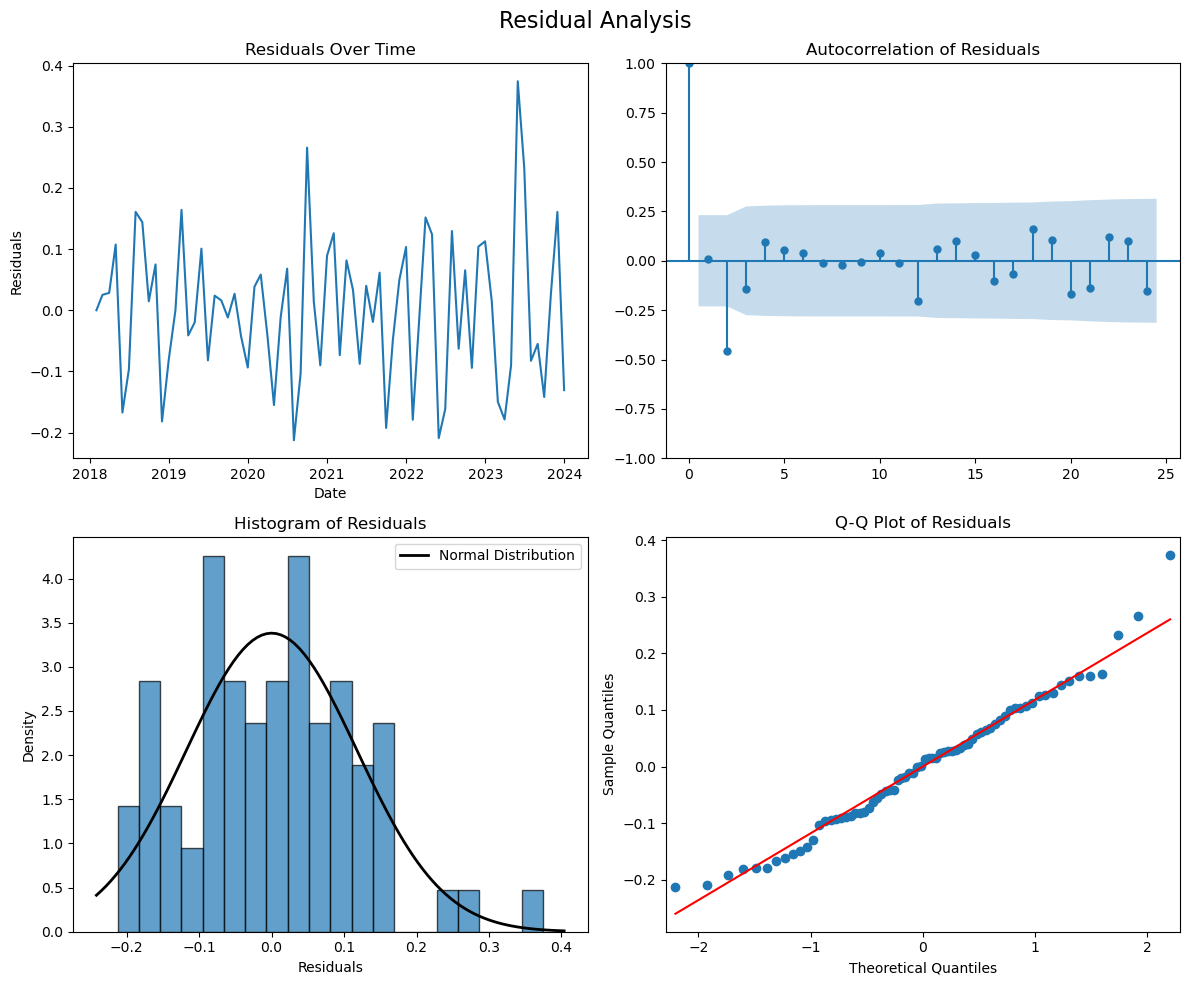

In [10]:
def plot_residual_analysis(residuals, figsize=(12, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Residual Analysis', fontsize=16)

    # Plot 1: Residuals Over Time
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title('Residuals Over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Residuals')

    # Plot 2: ACF of Residuals
    sm.graphics.tsa.plot_acf(residuals, lags=24, ax=axes[0, 1])
    axes[0, 1].set_title('Autocorrelation of Residuals')

    # Plot 3: Histogram of Residuals with Normal Curve
    mu, std = np.mean(residuals), np.std(residuals)
    axes[1, 0].hist(residuals, bins=20, density=True, alpha=0.7, edgecolor='black')
    xmin, xmax = axes[1, 0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axes[1, 0].plot(x, p, 'k', linewidth=2, label='Normal Distribution')
    axes[1, 0].set_title('Histogram of Residuals')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()

    # Plot 4: Q-Q Plot
    sm.qqplot(residuals, line='s', ax=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.show()

# Calculate residuals
residuals = normalized_cases - fitted_model_normalized.fittedvalues

# Generate all plots
plot_residual_analysis(residuals)